## Calibration of a line to data

Simple demo demonstrating the workflow of `rxmc`.

In [1]:
import rxmc

Using database version X4-2024-12-31 located in: /home/beyerk/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [2]:
from collections import OrderedDict

import corner
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

## define parameters

In [3]:
help(rxmc.params.Parameter)

Help on class Parameter in module rxmc.params:

class Parameter(builtins.object)
 |  Parameter(name, dtype=<class 'float'>, unit='', latex_name=None, bounds=None)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, name, dtype=<class 'float'>, unit='', latex_name=None, bounds=None)
 |      Parameters:
 |          name (str): Name of the parameter
 |          dtype (np.dtype): Data type of the parameter
 |          unit (str): Unit of the parameter
 |          latex_name (str): LaTeX representation of the parameter
 |          bounds (tuple, optional): Bounds for the parameter as a tuple (min, max)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables
 |  
 |  __weakref__
 |      list of weak references to the object



## make the model

In [4]:
help(rxmc.physical_model.PhysicalModel)

Help on class PhysicalModel in module rxmc.physical_model:

class PhysicalModel(builtins.object)
 |  PhysicalModel(params: list[rxmc.params.Parameter])
 |  
 |  Represents an arbitrary parameteric model $y_{model}(x;params)$, for
 |  comparison to some experimental measurement $\{x_i, y(x_i)\}$ contained
 |  in an Observation object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, observation: rxmc.observation.Observation, *params) -> numpy.ndarray
 |      Call self as a function.
 |  
 |  __init__(self, params: list[rxmc.params.Parameter])
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  evaluate(self, observation: rxmc.observation.Observation, *params) -> numpy.ndarray
 |      Evaluate the model at the given parameter values.
 |      Should be overridden by subclasses.
 |      
 |      Parameters:
 |      ----------
 |      observation: Observation object containing x and y data.
 |      params: Parameters for the model, should match the model's p

# Clearly to make a model, we need to understand these things called `Observation`s. 

This is an important detail, the whole point of `rxmc` is to compare predictions of a `PhysicalModel` to data contained in an `Observation`, to calibrate the parameters of the `PhysicalModel`.

In [5]:
help(rxmc.observation.Observation)

Help on class Observation in module rxmc.observation:

class Observation(builtins.object)
 |  Observation(x: numpy.ndarray, y: numpy.ndarray, y_stat_err=None, y_sys_err_normalization=0.0, y_sys_err_offset=0.0)
 |  
 |  A class to represent an observation with associated errors.
 |  
 |  Attributes:
 |  ----------
 |  x : np.ndarray
 |      The independent variable data.
 |  y : np.ndarray
 |      The dependent variable data.
 |  y_stat_err : np.ndarray, optional
 |      The statistical error associated with y. Defaults to an array of
 |      zeros with the same shape as y.
 |  y_sys_err_normalization : float, optional
 |      The systematic error normalization associated with y. Defaults to 0.0.
 |  y_sys_err_offset : float, optional
 |      The systematic error offset associated with y. Defaults to 0.0.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, x: numpy.ndarray, y: numpy.ndarray, y_stat_err=None, y_sys_err_normalization=0.0, y_sys_err_offset=0.0)
 |      Initialize self. 

Ok, so basically it's just some `x` and `y`, ans some information about the errors of `y`. We can think of `Observation`s like experimental measurements of an observable, and we want to build a model to make uncertainty-quantified predictions of that observable.

In [6]:
class LinearModel(rxmc.physical_model.PhysicalModel):
    def __init__(self):
        params = [
            rxmc.params.Parameter("m", float, "no-units"),
            rxmc.params.Parameter("b", float, "y-units"),
        ]
        super().__init__(params)

    def evaluate(self, observation, m, b):
        return self.y(observation.x, m, b)

    def y(self, x, m, b):
        # useful to have a function hat takes in an array-like x
        # rather than an Observation, e.g. for plotting
        return m * x + b

Well that's not too complicated.

In [7]:
my_model = LinearModel()

Let's test it out:

In [8]:
# true params are obviously m = 1, b = 0
observation = rxmc.observation.Observation(x=np.array([1, 2, 3]), y=np.array([1, 2, 3]))
my_model(observation, 1, 0)

array([1, 2, 3])

In [9]:
my_model.y(observation.x, 2, 1)

array([3, 5, 7])

In [10]:
# now with parameters that are obviously wrong
my_model(observation, 2, 1)

array([3, 5, 7])

In [11]:
# just to show some ways that may be convenient to pass around params
# note they must be in the same order as in my_model.evaluate,
# which should be in the same order as my_model.params

p = [2, 1]
print(my_model(observation, *p))
p = np.array([2, 1])
print(my_model(observation, *p))

[3 5 7]
[3 5 7]


## define a prior

Let's imagine this line corresponds to some physics, and we have some backround knowledge to inform us what we expect $m$ and $b$ to be. We can encode that into a prior distribution:

In [12]:
prior_mean = OrderedDict(
    [
        ("m", 1),
        ("b", 1),
    ]
)
prior_std_dev = OrderedDict(
    [
        ("m", 0.3),
        ("b", 1),
    ]
)

In [13]:
covariance = np.diag(list(prior_std_dev.values())) ** 2
mean = np.array(list(prior_mean.values()))

In [14]:
n_prior_samples = 100000
prior_distribution = stats.multivariate_normal(mean, covariance)
prior_samples = prior_distribution.rvs(size=n_prior_samples)

Let's plot some samples of lines from this prior

In [15]:
# dummy observation for plotting
x = np.linspace(0, 1, 10)

# array to hold the lines
y = np.zeros((n_prior_samples, len(x)))

# propagate the prior through to the observation
for i in range(n_prior_samples):
    sample = prior_samples[i, :]
    y[i, :] = my_model.y(x, *sample)

# grab confidence intervals for plotting
upper, lower = np.percentile(y, [5, 95], axis=0)

Text(0.5, 1.0, 'prior')

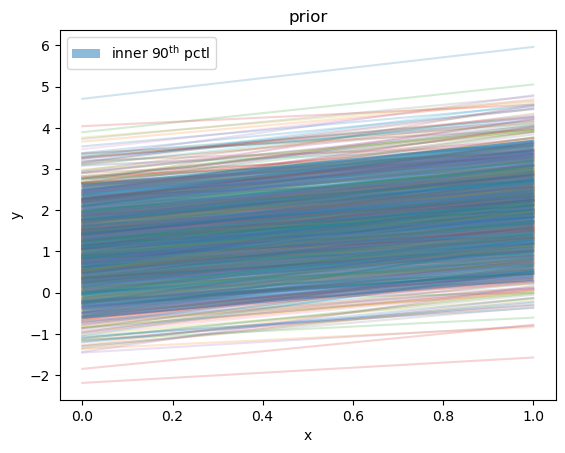

In [16]:
for i in np.random.choice(n_prior_samples, 1000):
    plt.plot(x, y[i, :], zorder=1, alpha=0.2)
    # pass

plt.fill_between(
    x, lower, upper, alpha=0.5, zorder=2, label=r"inner 90$^\text{th}$ pctl"
)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("prior")

Text(0.5, 0.98, 'prior')

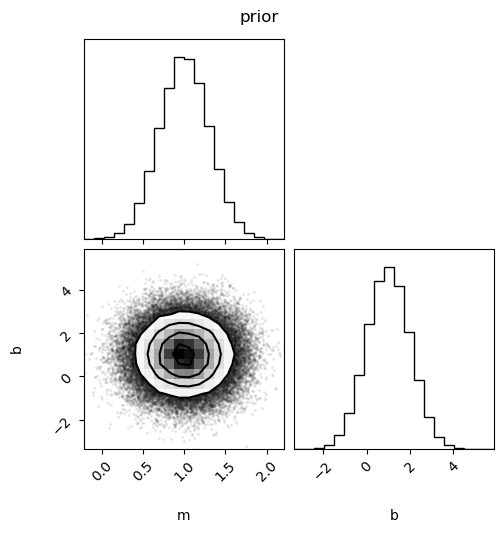

In [17]:
fig = corner.corner(prior_samples, labels=[p.name for p in my_model.params])
fig.suptitle("prior")

## Now let's update our prior by comparing to some data

This will require learning about `LikelihoodModel`s in `rxmc`. These encode our assumptions about the error on an experimental `Observation`, and are a necessary ingredient for comparing to the predictions of a `PhysicalModel`.

In our case we will mock experimental data by synthetically generate some data with noise about a "true" $m$ and $b$. Our calibration posterior should converge to be centered about this true point.

Let us assume that the experimentalists made a perfect estimate of the experimental noise in their setup. That is, the error bars they report will correspond exactly to the true distribution from which we sample.

This noise will correspond to statistical noise. Later on we will look at systematic experimental error.

In [18]:
rng = np.random.default_rng(13)

In [19]:
true_params = OrderedDict(
    [
        ("m", 0.6),
        ("b", 2),
    ]
)

noise = 0.05
x = np.linspace(0.01, 1.0, 10, dtype=float)
y_exp = my_model.y(x, *list(true_params.values())) + rng.normal(
    scale=noise, size=len(x)
)
y_stat_err = noise * np.ones_like(y_exp)  # noise is just a constant fraction of y
obs1 = rxmc.observation.Observation(x=x, y=y_exp, y_stat_err=y_stat_err)

Text(0.5, 1.0, 'experimental constraint')

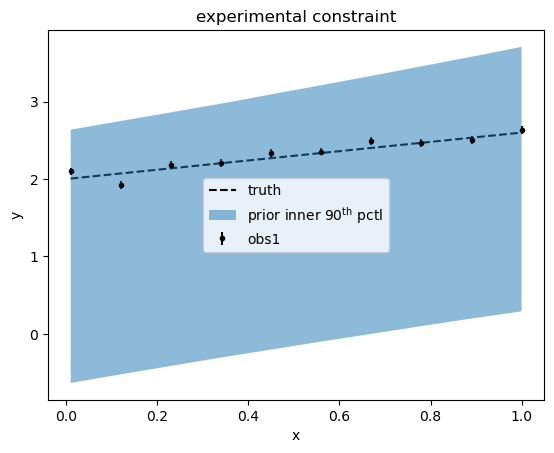

In [20]:
plt.errorbar(
    x,
    obs1.y,
    obs1.y_stat_err,
    color="k",
    marker=".",
    linestyle="none",
    label="obs1",
)
plt.plot(x, my_model.y(x, *list(true_params.values())), "k--", label="truth")
plt.xlabel("x")
plt.ylabel("y")

plt.fill_between(
    x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"prior inner 90$^\text{th}$ pctl",
)

plt.legend()
plt.title("experimental constraint")

Clearly, our prior is at odds with our observation. We will now determine a posterior distribution of $m$ and $b$ that takes `obs1` into account. To do this, we will need to think about a `LikelihoodModel` for `obs1`.

## set up `LikelihoodModel` and `Constraint`.

We will use the simplest assumption about the error on y: that the experimentalists exactly reported the statistical error, and there is no systematic error at all. This implies that each data point in `obs1.y`, say `obs1.y[i]` can be modeled as being an random variate, each sampled independently from normal distributions with mean `obs1.y[i]` and with standard deviation `obs1.y_stat_err[i]`.

This corresponds to the simplest `LikelihoodModel`: the `FixedCovarianceLikelihood`.

In [21]:
help(rxmc.likelihood_model.FixedCovarianceLikelihood)

Help on class FixedCovarianceLikelihood in module rxmc.likelihood_model:

class FixedCovarianceLikelihood(LikelihoodModel)
 |  A special LikelihoodModel to handle FixedCovarianceObservation objects,
 |  where the covariance matrix is fixed and does not depend on the
 |  parameters of the PhysicalModel.
 |  
 |  This allows for the use of precomputed inverse covariance matrices which
 |  can speed up the calculation of the chi-squared statistic and logpdf.
 |  
 |  Method resolution order:
 |      FixedCovarianceLikelihood
 |      LikelihoodModel
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  chi2(self, observation: rxmc.observation.FixedCovarianceObservation, ym: numpy.ndarray)
 |      Calculate the generalised chi-squared statistic. This is the
 |      Malahanobis distance between y and ym
 |      
 |      Parameters
 |      ----------
 |      params : OrderedDict
 |        

Note that this requires that `obs1` is a `FixedCovarianceObservation`:

In [22]:
help(rxmc.observation.FixedCovarianceObservation)

Help on class FixedCovarianceObservation in module rxmc.observation:

class FixedCovarianceObservation(Observation)
 |  FixedCovarianceObservation(x: numpy.ndarray, y: numpy.ndarray, covariance: numpy.ndarray)
 |  
 |  A class to represent an observation with fixed covariance. That is, the
 |  covariance matrix for the Multivariate Gaussian likelihood for a model
 |  prediction ym is known a priori and does not change with the model
 |  prediction.
 |  
 |  The simplest such case is when the covariance is a diagonal matrix
 |  containing the reported statistical variances for each data point in y.
 |  
 |  In the case that the covariance is a vector, it is interpreted as the
 |  diagonal of the covariance matrix, and the likelihood reduces to the
 |  standard form using the chi-squared statistic. In the case that the
 |  covariance is a full matrix, this corresponds to the generalised
 |  chi-squared statistic.
 |  
 |  Method resolution order:
 |      FixedCovarianceObservation
 |    

In [23]:
obs1 = rxmc.observation.FixedCovarianceObservation(
    obs1.x,
    obs1.y,
    np.diag(obs1.y_stat_err**2),
)

In [24]:
likelihood_model = rxmc.likelihood_model.FixedCovarianceLikelihood()

In [25]:
constraint = rxmc.constraint.Constraint(
    [obs1],
    my_model,
    likelihood_model,
)

Let's test this `constraint` thing out. What is the reduced $\chi^2$ for the prior mean?

In [26]:
constraint.chi2(prior_distribution.mean) / constraint.n_data_pts

np.float64(273.36462027714936)

In this simple case, this reduces to the familar formula for the reduced $\chi^2$:

In [27]:
y = my_model(obs1, *prior_distribution.mean)
np.sum((y - obs1.y) ** 2 / np.diag(obs1.covariance)) / constraint.n_data_pts

np.float64(273.3646202771494)

## running the calibration

In [28]:
help(rxmc.mcmc.run_chain)

Help on function run_chain in module rxmc.mcmc:

run_chain(prior, corpus: rxmc.corpus.Corpus, nsteps: int, burnin: int = 0, seed: int = 42, batch_size: int = None, rank: int = 0, proposal_cov_scale_factor: float = 100, verbose: bool = True, output: pathlib.Path = None)
    Runs the MCMC chain with the specified parameters.
    
    Parameters:
        prior (object): The prior distribution object with mean, cov attributes
            and a logpdf method.
        corpus (corpus.Corpus): The corpus object with a logpdf method.
        nsteps (int): Total number of steps for the MCMC chain.
        batch_size (int): Number of steps per batch.
        burnin (int): Number of initial steps to discard.
        seed (int): Random seed for generating random numbers.
        rank (int): MPI rank for the current process.
        proposal_cov_scale_factor (float): Scale factor for the proposal
            covariance.
        verbose (bool): Flag to print extra logging information.
        output 

First we need to make a Corpus. With one constraint this seems trivial, but this will be useful down the road when we may want to combine multiple constraints together.

In [29]:
help(rxmc.corpus.Corpus)

Help on class Corpus in module rxmc.corpus:

class Corpus(builtins.object)
 |  Corpus(constraints: list[rxmc.constraint.Constraint], weights: numpy.ndarray = None, likelihood_params: list[rxmc.params.Parameter] = None)
 |  
 |  A collection of independent `Constraint`s that can be used to fit a common
 |  physical model.
 |  
 |  Each `Constraint` represents a set of `Observation`s and a `LikelihoodModel`.
 |  Each `Constraint` must share the same `PhysicalModel` parameters, but may
 |  have different `LikelihoodModel` parameters.
 |  
 |  This class is designed to aggregate multiple constraints, so that, for a
 |  given set of physical model parameters (and, optionally, likelihood model
 |  parameters), a log likelihood can be computed.
 |  
 |  Optionally, weights can be assigned to each constraint, which will
 |  scale the contribution of each constraint to the total log likelihood.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, constraints: list[rxmc.constraint.Constraint],

In [30]:
corpus = rxmc.corpus.Corpus([constraint])

In [31]:
%%time
# run a single chain
logl, chain, accepted_frac = rxmc.mcmc.run_chain(
    prior_distribution, corpus, nsteps=10000, burnin=1000, verbose=True
)

Rank: 0. Burn-in batch 1/1 completed, 1000 steps.
Rank: 0. Batch: 1/1 completed, 9000 steps. Acceptance frac: 0.178
CPU times: user 2.56 s, sys: 3.96 ms, total: 2.56 s
Wall time: 2.56 s


In [32]:
[m.name for m in my_model.params]

['m', 'b']

In [33]:
true_params

OrderedDict([('m', 0.6), ('b', 2)])

Text(0.5, 0, '$i$')

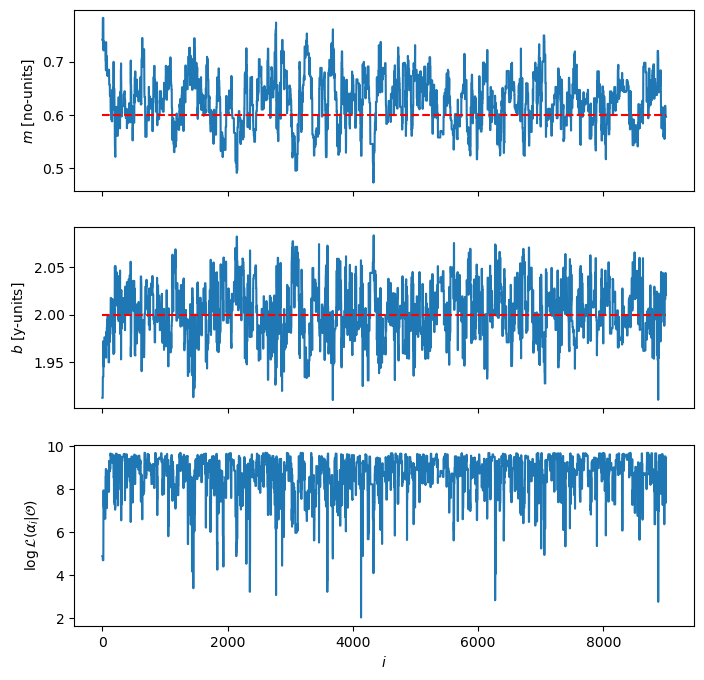

In [34]:
fig, axes = plt.subplots(chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True)
for i in range(chain.shape[1]):
    axes[i].plot(chain[:, i])
    axes[i].set_ylabel(f"${my_model.params[i].latex_name}$ [{my_model.params[i].unit}]")
    true_value = true_params[my_model.params[i].name]
    axes[i].hlines(true_value, 0, len(chain), "r", linestyle="--")


axes[-1].plot(logl)
axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

axes[-1].set_xlabel(r"$i$")
# plt.legend(title="chains", ncol=3,)

In [35]:
posterior_range = np.vstack([np.min(chain, axis=0), np.max(chain, axis=0)]).T

Text(0.5, 0.98, 'posterior')

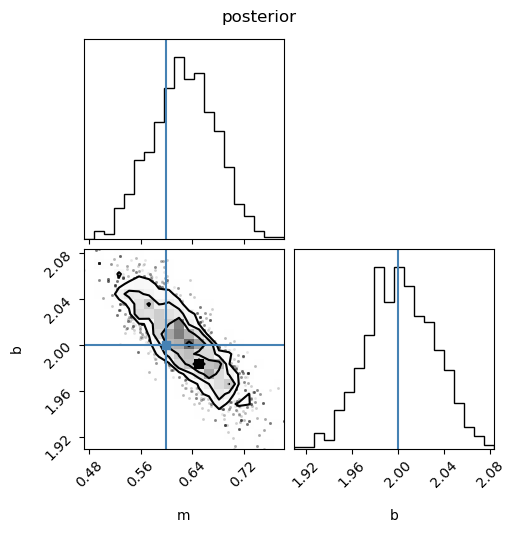

In [36]:
fig = corner.corner(
    chain,
    labels=[p.name for p in my_model.params],
    label="posterior",
    truths=[true_params["m"], true_params["b"]],
)
fig.suptitle("posterior")

In [37]:
n_posterior_samples = chain.shape[0]
y = np.zeros((n_posterior_samples, len(x)))
for i in range(n_posterior_samples):
    sample = chain[i, :]
    y[i, :] = my_model.y(x, *sample)

upper, lower = np.percentile(y, [5, 95], axis=0)

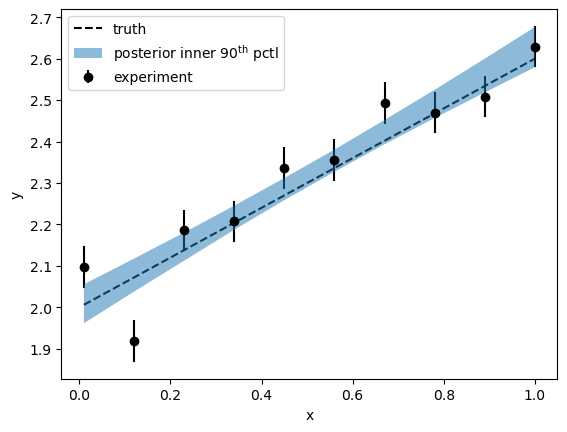

In [38]:
plt.plot(x, my_model.y(x, *list(true_params.values())), "k--", label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.errorbar(
    x,
    obs1.y,
    np.diag(np.sqrt(obs1.covariance)),
    color="k",
    marker="o",
    linestyle="none",
    label="experiment",
)
plt.fill_between(
    x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"posterior inner 90$^\text{th}$ pctl",
)

plt.legend()
# plt.title("predictive posterior")

# Nice!

Hopefully this simple example served to illustrate the basic function of the working pieces of `rxmc`. The true power is the ability to compose different `Constraint`s, and easily manage and test different model forms for both the `PhysicalModel` and `LikelihoodModel`. In particular, the very simple `LikelihoodModel` we used in this example is very often inadequate in real world situations where systematic errors may be present, or we may want to fit experimental errors themselves in addition to model parameters.


Additionally, real applications should run multiple chains with different random seeds and starting locations to avoid autocorrelation within a chain.

Check out the other demos to see how `rxmc` helps us handle these real-world problems.